<a href="https://colab.research.google.com/github/KarolChlasta/PJAIT-AdvancedML/blob/master/1.DataClassification/char-rnn-classification-pl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://i.imgur.com/eBRPvWB.png)

# Klasyfikacja nazwisk z użyciem sieci rekurencyjnych przetwarzających litery

Będziemy budować i trenować klasyfikator RNN przetwarzający znaki, aby klasyfikował słowa. Znakowy RNN odczytuje słowa jako serię znaków - wyprowadzając prognozę i "stan ukryty" na każdym kroku, wprowadzając swój poprzedni stan ukryty do każdego kolejnego kroku. Końcową prognozę potraktujemy jako wynik, tj. klasę, do należy dane słowo.

Mówiąc dokładniej, przeprowadzimy trening sieci na kilku tysiącach nazwisk pochodzących z 18 języków, i będziemy rozpoznawać język z którego nazwisko pochodzi:

```
> Czarnowski
(79.13%) Polish
( 6.21%) Russian
( 6.04%) Czech

> Satoshi
(47.51%) Japanese
(26.99%) Arabic
(10.29%) Polish
```

# Polecana lektura

Zakładam że jest już zainstalowany PyTorch, znasz Python'a, oraz znasz pojęcie Tensor'ów:

* http://pytorch.org/ - instalacja PyTorch
* [Deep Learning with PyTorch: A 60-minute Blitz](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) - Podstawy PyTorch
* [jcjohnson's PyTorch examples](https://github.com/jcjohnson/pytorch-examples) przykłady wykorzystania PyTorch
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb) jeżeli znasz Lua Torch

Trochę wiedzy o RNN:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) przykłady z życia wzięte
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) RNN i LSTM w pigułce

# Ustawianie środowiska pod RNN-classification

## Instalacja PyTorch

In [1]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

import torch

     |████████████████████████████████| 484.0MB 1.1MB/s 
ERROR: torchvision 0.4.2 has requirement torch==1.3.1, but you'll have torch 0.4.0 which is incompatible.
ERROR: fastai 1.0.59 has requirement torch>=1.0.0, but you'll have torch 0.4.0 which is incompatible.


## Instalacja bibliotek

In [2]:
!pip install -q unidecode tqdm pysmi

     |████████████████████████████████| 245kB 5.0MB/s 
     |████████████████████████████████| 81kB 13.1MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 


## Instalacja biblioteki PyDrive wrapper & import 

In [0]:
# This only needs to be done once per notebook.
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from pathlib import Path
import os

def download_and_save(file_name, file_id):
  downloaded = drive.CreateFile({'id': file_id})
  # fetch file
  downloaded.FetchContent()
  # write file
  with open(file_name,'wb') as f:
       f.write(downloaded.content.read())
      
  print(f'Saved {file_name}')
  
FILE_NAME, FILE_ID = ['file_name', 'file_id']

# Pobranie danych

In [4]:
from pathlib import Path
dataset_path = Path('/content/')
!ls -lh $dataset_path/
!pwd

total 8.0K
-rw-r--r-- 1 root root 2.7K Nov 22 20:31 adc.json
drwxr-xr-x 1 root root 4.0K Nov 21 16:30 sample_data
/content


## Pobranie datasetu data-names

In [5]:
# data-names.tgz, https://drive.google.com/file/d/17tzhbLwlfdIsimJDTNghFfx22cT9n7OB
names = {FILE_NAME: 'data-names.tgz', FILE_ID: '17tzhbLwlfdIsimJDTNghFfx22cT9n7OB'}
names_path = dataset_path / names[FILE_NAME]

download_and_save(names_path, names[FILE_ID])

Saved /content/data-names.tgz


In [0]:
# unpack

!tar -xf $names_path -C $dataset_path

In [7]:
!ls -lh $dataset_path/data/names

total 200K
-rw-r--r-- 1 501 staff  13K Apr 20  2018 Arabic.txt
-rw-r--r-- 1 501 staff 1.3K Apr 20  2018 Chinese.txt
-rw-r--r-- 1 501 staff 3.9K Apr 20  2018 Czech.txt
-rw-r--r-- 1 501 staff 2.3K Apr 20  2018 Dutch.txt
-rw-r--r-- 1 501 staff  27K Apr 20  2018 English.txt
-rw-r--r-- 1 501 staff 2.2K Apr 20  2018 French.txt
-rw-r--r-- 1 501 staff 5.5K Apr 20  2018 German.txt
-rw-r--r-- 1 501 staff 2.0K Apr 20  2018 Greek.txt
-rw-r--r-- 1 501 staff 1.9K Apr 20  2018 Irish.txt
-rw-r--r-- 1 501 staff 5.6K Apr 20  2018 Italian.txt
-rw-r--r-- 1 501 staff 7.5K Apr 20  2018 Japanese.txt
-rw-r--r-- 1 501 staff  423 Apr 20  2018 Korean.txt
-rw-r--r-- 1 501 staff 1.2K Apr 20  2018 Polish.txt
-rw-r--r-- 1 501 staff  554 Apr 20  2018 Portuguese.txt
-rw-r--r-- 1 501 staff  84K Apr 20  2018 Russian.txt
-rw-r--r-- 1 501 staff  752 Apr 20  2018 Scottish.txt
-rw-r--r-- 1 501 staff 2.3K Apr 20  2018 Spanish.txt
-rw-r--r-- 1 501 staff  339 Apr 20  2018 Vietnamese.txt


# Opcjonalna integracja z Dyskiem Google



In [8]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive -o nonempty

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145605 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.13-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

# Monitorowanie maszyny wirtualnej

In [9]:
!uptime

 20:32:59 up 3 min,  0 users,  load average: 0.42, 0.36, 0.16


# Przygotowanie danych

Dane znajdują się w folderze `data/names` są podzielone na 18 plików tekstowych nazwanych wg schematu "[Language].txt". Każdy plik zawiera wiele nazwisk, po 1 w każdej linii w losowej kolejności, w większości zapisanych alfabetem łacińskim.

Otrzymamy coś w rodzaju słownika (python dictionary) składającego się z list nazwisk dla każdego z języków, `{language: [names ...]}`. Ogólne zmienne "category" oraz "line" (dla języka i nazwiska w naszym przypadku) są używane dla zapewnienia przyszłej rozszerzalności.

In [10]:
import glob

all_filenames = glob.glob('data/names/*.txt')
print(all_filenames)

['data/names/Polish.txt', 'data/names/Italian.txt', 'data/names/Vietnamese.txt', 'data/names/Scottish.txt', 'data/names/Arabic.txt', 'data/names/Greek.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/French.txt', 'data/names/English.txt', 'data/names/German.txt', 'data/names/Portuguese.txt', 'data/names/Japanese.txt', 'data/names/Czech.txt', 'data/names/Irish.txt', 'data/names/Russian.txt', 'data/names/Spanish.txt', 'data/names/Chinese.txt']


In [11]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return lines

for filename in all_filenames:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print('n_categories =', n_categories)

n_categories = 18


In [12]:
all_letters = ''.join(sorted(list(set(''.join([''.join(v) for k,v in category_lines.items()])))))
n_letters = len(all_letters)

print(f'all_letters = {all_letters}')
print(f'n_letters = {n_letters}')

all_letters =  ',-/1:ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz ÁÉßàáãäçèéêìíñòóõöùúüąłńŚŻż
n_letters = 87


Teraz mamy "category_lines", słownik mapujący każdą kategorię (język) do listy nazwisk. Przechowujemy także "all_categories" (po prostu lsitę języków) oraz "n_categories" dla przyszłego użytku.

In [13]:
c = category_lines['Polish']; print(len(c))
print(c[:5])

139
['Adamczak', 'Adamczyk', 'Andrysiak', 'Auttenberg', 'Bartosz']


# Konwersja nazwisk na tensory

Teraz jak już wszystkie nazwiska są poukładane, musimy je przekonwertować na tensory.

Do reprezentacji pojedynczej litery używamy kodowania 1-z-n (ang. one-hot vector) o rozmiarze <1 x n_letters>. Wektor 1-z-n jest wypełniony zerami za wyjątkiem 1 znajdującej w miejscu przynależnym do pożądanej litery np. `"b" = <0 1 0 0 0 ...>`.

Aby zbudować słowo łączymy kilka takich wektorów w pojedynczą macierz o wymiarach: `<line_length x 1 x n_letters>`.

Dodatkowy wymiar oznaczony 1 jest potrzebny ponieważ PyTorch zakłada że wszystko jest ładowane porcjami (ang. batch) - my tu używamy porcji o rozmiarze równym 1.


In [0]:
import torch

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

In [15]:
print(letter_to_tensor('c'))

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.]])


In [16]:
print(line_to_tensor('Jones').size())

torch.Size([5, 1, 87])


# Budowa sieci rekurencyjnej

Przed zastosowaniem metody autograd, stworzenie RNN w Torchu wiązało się z klonowaniem parametrów warstwy dla kolejnych kroków. Warstwy przechowywały stany ukryte oraz gradienty, które obecnie są całkowicie obsługiwane przez graf. Oznaczna to że możesz zaimplementować RNN w bardzo przystępnej formie podobnie jak zwyczajne wartwy feed-forward.

Ten moduł RNN (zainspirowany [the PyTorch for Torch users tutorial](https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-2-recurrent-net)) to tylko 2 linearne warstwy, które operują na wejściu oraz stanie ukrytym, a także aplikują warstwę LogSoftmax na wyjściu.

![](https://i.imgur.com/Z2xbySO.png)

In [0]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=-1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

## Ręczne testowanie sieci

Mając zdefiniowaną naszą klasę `RNN`, stwórzmy jej nową instancję:

In [18]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
print(rnn)

RNN(
  (i2h): Linear(in_features=215, out_features=128, bias=True)
  (i2o): Linear(in_features=215, out_features=18, bias=True)
  (softmax): LogSoftmax()
)


Aby uruchomić jakiś krok naszej sieci, musimy najpierw przekazać jakieś dane wejściowe (w tym przypadku Tensor bieżącej litery) oraz poprzedni stan ukryty (który inicjalizujemy na początku zerami). W taki sposób otrzymamy wynik (prawdopodobieństwo każdego języka) oraz następny stan ukryty (niezbędny w kolejnym kroku).

Pamiętaj że moduły PyTorch operują na Zmiennych (Variables), a nie bezpośrednio na Tensorach.


In [19]:
input = Variable(letter_to_tensor('A'))
hidden = rnn.init_hidden()

output, next_hidden = rnn(input, hidden)
print('output.size =', output.size())

output.size = torch.Size([1, 18])


Na potrzeby wydajności nie chcemy tworzyć nowego Tensora dla każdego kroku, więc używamy metody `line_to_tensor` zamiast `letter_to_tensor` a także tzw. wycinków (slices). Można to jeszcze zoptymalizować obliczając wcześniej porcje (batches) Tensorów.

In [20]:
input = Variable(line_to_tensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
output

tensor([[-3.0170, -2.9118, -2.9070, -2.8532, -2.8450, -3.0084, -2.7909,
         -2.9085, -2.7988, -2.9048, -2.8822, -2.8245, -2.8434, -2.9334,
         -2.9157, -2.8700, -2.9039, -2.9406]])

Tak jak widać wynikiem jest Tensor `<1 x n_categories>`, gdzie każdy element jest prawdopodobieństwem danej kategorii.

# Przygotowanie do treningu sieci

Zanim rozpoczeniemy trening musimy zaimplementować kilka funkcji pomocniczych.
Pierwsza to interpreter wyjść naszej sieci. Użyjemy tu `Tensor.topk` aby uzyskać indeks największej wartości:

In [21]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(category_from_output(output))

('Dutch', tensor(6))


Potrzebna będzie także metoda otrzymywania przykładów treningowych (nazwisko oraz język):


In [22]:
import random

def random_training_pair():                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print('category =', category, '/ line =', line)

category = German / line = Kraemer
category = Irish / line = Quinn
category = Polish / line = Dunajski
category = Russian / line = Murylev
category = Czech / line = Plisko
category = Korean / line = Rhee
category = Italian / line = Albrici
category = Korean / line = Ngai
category = Dutch / line = Alphen
category = Spanish / line = Robledo


# Trening sieci

Aby wytrenować sieć musimy jej "pokazać" wiele przykładów, pozwolić jej zgadywać i powiedzieć jej, kiedy się myli.

Na funkcję straty nadaje się metoda: [`nn.NLLLoss`](http://pytorch.org/docs/nn.html#nllloss), ponieważ ostatnia wartwa RNN to `nn.LogSoftmax`.

In [0]:
criterion = nn.NLLLoss()

Dodatkowo tworzymy 'optimizer', który będzie aktualizował parametry naszego modelu zależnie od gradientów. Wykorzystujemy tu zwykły algorytm SGD z małym tempem uczenia.

In [0]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

W każdej pętli treningu:

* Tworzymy wejściowe i oczekiwane tensory
* Tworzymy zerowy stan wejściowy
* Odczytujemy każdą literę
    * przechowujemy stan ukryty dla następnej litery
* Porównujemy otrzymany wynik z wartością oczekiwaną
* Robimy wsteczną propagację
* Zwracamy wynik i stratę

In [0]:
def train(category_tensor, line_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.item()

Teraz wystarczy to powtórzyć dla wielu próbek. Skoro funkcja `train` zwraca wynik i stratę można wypisać jej predykcje i śledzić wartości straty. Ponieważ mamy tysiące próbek wyświetlamy wyniki tylko co `print_every` kroków i liczymy średnią stratę.


In [26]:
import time
import math

n_epochs = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 3s) 2.4699 Bueren / Dutch ✓
10000 10% (0m 7s) 2.4325 Lindsay / Arabic ✗ (Scottish)
15000 15% (0m 11s) 1.1720 Maslanka / Polish ✓
20000 20% (0m 15s) 0.7504 Tiraboschi / Italian ✓
25000 25% (0m 19s) 3.4748 Fux / Chinese ✗ (German)
30000 30% (0m 23s) 1.6798 Tremblay / Irish ✗ (French)
35000 35% (0m 27s) 0.8331 Hong / Chinese ✓
40000 40% (0m 31s) 0.5466 Assaf / Arabic ✓
45000 45% (0m 35s) 1.8275 Guidi / Vietnamese ✗ (Italian)
50000 50% (0m 38s) 0.6516 Que / Chinese ✓
55000 55% (0m 42s) 1.5319 You / Korean ✗ (Chinese)
60000 60% (0m 46s) 1.6491 Lord / English ✓
65000 65% (0m 50s) 0.6998 Wang / Korean ✓
70000 70% (0m 54s) 0.3408 Mui / Chinese ✓
75000 75% (0m 58s) 1.3530 Kappel / Dutch ✓
80000 80% (1m 2s) 0.7753 Chau / Vietnamese ✓
85000 85% (1m 5s) 1.6990 Brose / French ✗ (German)
90000 90% (1m 9s) 0.7665 Teagan / Irish ✓
95000 95% (1m 13s) 0.7255 Cabello / Spanish ✓
100000 100% (1m 17s) 0.1481 Karnoupakis / Greek ✓


# Kreślenie wyników

Kreślenie historii straty z funkcji `all_losses` pokazuje przebieg uczenia sieci:

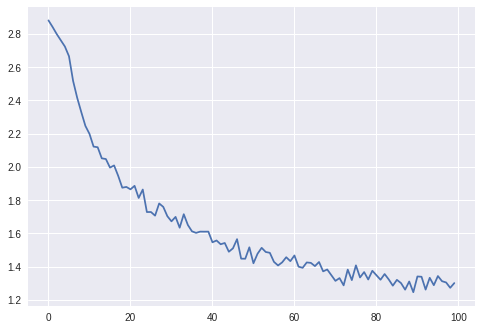

In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import matplotlib.style
import matplotlib as mpl
mpl.style.use('seaborn')

fig=plt.figure()
aaa = plt.plot(all_losses)

In [0]:
y = all_losses
n = 10
averages = []
for i in range(len(y) - n):
    window = y[i:i+n]
    avg = sum(window) / n
    # print(window, avg)
    averages.append(avg)

In [29]:
len(all_losses), len(averages)

(100, 90)

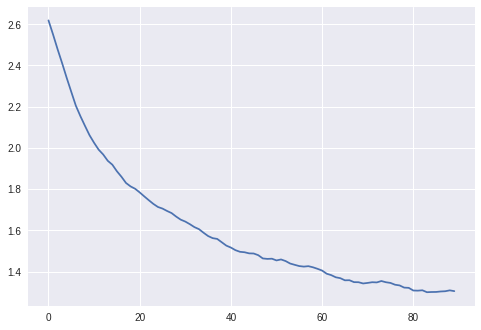

In [30]:
fig=plt.figure()
plt.plot(averages);

# Ocenianie wyników

Aby sprawdzić jak dobrze sieć radzi sobie z różnymi kategoriami tworzymy tablicę pomyłek, w której dla każdego języka (wiersz) pokazane są wyniki predykcji (kolumny). Aby wyliczyć tablicę pomyłek przepuszczamy serię próbek przez sieć funkcją  `evaluate()`,  która robie to samo co  `train()` za wyjątkiem wstecznej propagacji.

In [0]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

<Figure size 640x480 with 0 Axes>

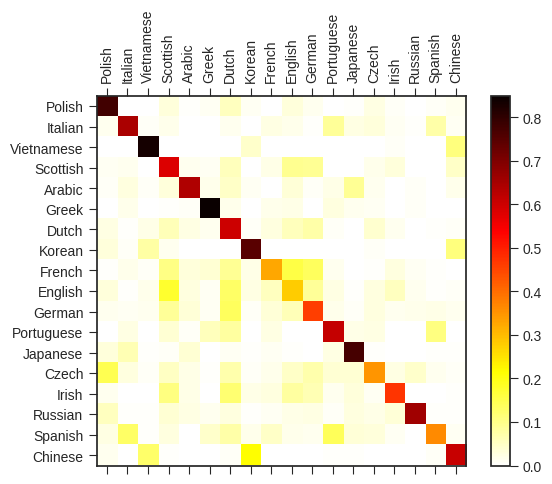

In [32]:
mpl.style.use('default')
mpl.style.use('seaborn-ticks')

mpl.pyplot.set_cmap('hot_r')

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

Wybierz widoczne kwadraciki poza główną przekątną aby zobaczyć, które przewidywania nie są prawidłowe, np. chiński zamiast koreańskiego czy hiszpański zamiast włoskiego. Widać, że klasyfikuje dobrze grecki, a słabo angielski (prawdopodobnie z powodu nakładania się z innymi językami).


# Klasyfikacja podanych nazwisk

In [33]:
import numpy as np

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(line_to_tensor(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        pred = np.exp(value)
        print('(%.2f%%) %s' % (pred*100, all_categories[category_index]))
        # print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Czarnowski')
predict('Kazimierczak')
predict('Wołk')


> Dovesky
(48.85%) Czech
(23.11%) Polish
(16.00%) Russian

> Jackson
(76.08%) Scottish
(12.70%) English
(4.72%) Russian

> Satoshi
(38.23%) Portuguese
(14.99%) Italian
(13.76%) Japanese

> Czarnowski
(99.12%) Polish
(0.38%) Czech
(0.28%) English

> Kazimierczak
(99.14%) Polish
(0.29%) Czech
(0.21%) Spanish

> Wołk
(27.38%) Czech
(26.06%) Polish
(16.27%) Korean


# Ćwiczenia

* Wypróbuj inny zbiór danych typu linia -> kategoria, np.:
    * słowo -> język
    * imię -> płeć
    * bohater -> pisarz
   
* Popraw wyniki tworząc większą sieć i/lub sieć o lepszej strukturze
    * Więcej linearnych warstw
    * Wypróbuj warstwy `nn.LSTM` oraz `nn.GRU` 
    * Połącz wiele takich sieci RNN w sieć wyższego rzędu